In [61]:
import anndata
import os
import requests

def read_link(link, save_path):
    if not os.path.exists(save_path):
        response = requests.get(link)
        with open(save_path, "wb") as f:
            f.write(response.content)

    return anndata.read_h5ad(save_path)

MOBSC_sce = read_link("https://go.wisc.edu/yeo402", "data/MOBSC_sce.h5ad")
MOBSP_sce = read_link("https://go.wisc.edu/n7bcr6", "data/MOBSP_sce.h5ad")

exper = {
    "sc": read_link("https://go.wisc.edu/yeo402", "data/MOBSC_sce.h5ad"),
    "sp": read_link("https://go.wisc.edu/n7bcr6", "data/MOBSP_sce.h5ad")
    }

We haven't implemented differential variance in the current copula estimator! This is a simple extension -- let's make sure to add it.

In [63]:
from scdesigner.simulators import NegBinCopulaSimulator
import pandas as pd

 # need to make this automatic
exper["sc"].obs["_copula_group"] = pd.Categorical(exper["sc"].n_obs * ["shared_group"])
exper["sp"].obs["_copula_group"] = pd.Categorical(exper["sp"].n_obs * ["shared_group"])

# estimate model
formulas = {"sc": "~ cellType", "sp": "~ bs(spatial1, df=40) + bs(spatial2, df=40)"}
sims = {k: NegBinCopulaSimulator(epochs=1) for k in exper.keys()}
{v.fit(exper[k], formulas[k], copula_groups="_copula_group") for k, v in sims.items()}

{None}

We need also a function to get the mean matrices. This is like "predict" in R.

In [64]:
means = {k: v.predict(exper[k].obs)["mean"] for k, v in sims.items()}

In [87]:
means

{'sc':                         Grin2b     Prkca      Ano3     Gria3     Kank3  \
 WT1_AAACCTGAGCTGCGAA  1.805551  0.762779  0.561307  0.529556  0.529400   
 WT1_AAACCTGGTTTGGCGC  1.805551  0.762779  0.561307  0.529556  0.529400   
 WT1_AAACGGGAGATCCGAG  1.805551  0.762779  0.561307  0.529556  0.529400   
 WT1_AAACGGGGTAAGTGGC  1.805551  0.762779  0.561307  0.529556  0.529400   
 WT1_AAAGATGTCATCGGAT  2.166593  0.253126  0.162809  0.156958  0.178117   
 ...                        ...       ...       ...       ...       ...   
 OC2_TAAGTGCGTTTGTTGG  1.262526  0.322645  0.178852  0.180342  0.166671   
 OC2_TACGGTAGTAAATGTG  1.262526  0.322645  0.178852  0.180342  0.166671   
 OC2_TACTTACGTAGGCATG  1.262526  0.322645  0.178852  0.180342  0.166671   
 OC2_TAGTTGGTCGCGATCG  1.262526  0.322645  0.178852  0.180342  0.166671   
 OC2_TTGCGTCAGGATCGCA  1.262526  0.322645  0.178852  0.180342  0.166671   
 
                           Penk     Icam5    Sema3c     Kcnb2  Il1rapl1  ...  \
 WT1_AAACCTG

In [88]:
exper["sc_sim"] = sims["sc"].sample(exper["sc"].obs)

In [122]:
import tangram as tg
import numpy as np
from copy import deepcopy

def signatures(means, cell_types):
    result = np.zeros((len(cell_types), means.n_vars))
    for k, cell_type in enumerate(cell_types):
        ix = np.where(np.array(cell_types) == cell_type)[0]
        result[k, :] = means.X[ix, :].mean(axis=1)
    return result

mean_adata = {k: deepcopy(v) for k, v in exper.items()}
for k in ["sp", "sc"]:
    mean_adata[k].X = means[k]

cell_types = list(exper["sc"].obs["cell_type"].dtype.categories)
sn_adata = anndata.AnnData(
    obs = exper["sc"].obs[:4], 
    X = signatures(mean_adata["sc"], cell_types)
)
sn_adata.obs["cell_type"] = cell_types

tg.pp_adatas(exper["sc"], mean_adata["sp"])
adata_map = tg.map_cells_to_space(exper["sc"], mean_adata["sp"])

INFO:root:182 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:182 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 182 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.998, KL reg: 0.000
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: -0.000
Score: 1.000, KL reg: -0.000
Score: 1.000, KL reg: -0.000
Score: 1.000, KL reg: -0.000
Score: 1.000, KL reg: -0.000
Score: 1.000, KL reg: -0.000
Score: 1.000, KL reg: -0.000
Score: 1.000, KL reg: -0.000


INFO:root:Saving results..


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


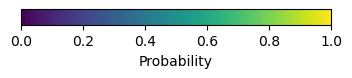

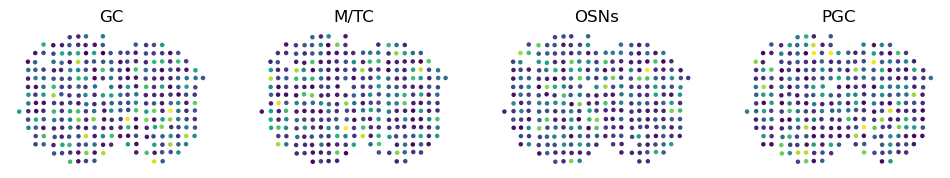

In [116]:
import tangram.plot_utils as pl

pl.plot_cell_annotation(adata_map, exper["sp"], x="spatial1", y="spatial2", ncols=4)

In [117]:
tg.project_cell_annotations(adata_map, exper["sp"])
mixtures = exper["sp"].obsm["tangram_ct_pred"]

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [118]:
import numpy as np

exper["sp_sim"] = exper["sp"].copy()
exper["sp_sim"].X = np.zeros_like(exper["sp"].X)
n_cells = len(exper["sp"])
cells_per_spot = 50, 5

In [119]:
exper["sp_sim"] = exper["sp"].copy()

for n in range(n_cells):
    for k in cell_types:
        # get a random subset of cells of this type
        candidate = np.where(exper["sc_sim"].obs["cell_type"] == k)[0]
        ix = np.random.choice(candidate, size=cells_per_spot[0])

        # simulate according to the deconvolution result
        depths = exper["sc_sim"].X[ix, :].sum(axis=0)
        exper["sp_sim"].X[[n], :] += np.ceil(depths * mixtures[k][n] / cells_per_spot[1])

In [120]:
exper["sp_sim2"] = exper["sp"].copy()
exper["sp_sim2"].X = mixtures @ signatures

IndexError: tuple index out of range

In [ ]:
import squidpy as sq
import scanpy as sc

markers = ["penk", "apold1", "cdhr1", "s100a5"]
exper["sp"].obsm["spatial"] = exper["sp"].obs[["spatial1", "spatial2"]].values
exper["sp_sim2"].obsm["spatial"] = exper["sp"].obsm["spatial"]
exper["sp_sim"].obsm["spatial"] = exper["sp"].obsm["spatial"]

In [ ]:
sc.pl.spatial(exper["sp"], color=markers, spot_size=0.8)

In [ ]:
sc.pl.spatial(exper["sp_sim2"], color=markers, spot_size=0.8)

In [ ]:
sc.pl.spatial(exper["sp_sim"], color=markers, spot_size=0.8)